# Time Series Analysis: MARA
In this notebook, we will perform a time series analysis on the historical stock price for MARA denoting Marathon Digital Holdings, Inc. The company operates as a digital asset technology company that mines cryptocurrencies with a focus on the blockchain ecosystem and the generation of digital assets in United States. As of December 31, 2021, it had approximately 8,115 bitcoins, which included the 4,794 bitcoins held in the investment fund.

## Table of Contents
1. Environment set-up
2. Initial Diagonistics
    * Basic Visualization
3. Decomposition
    * Detrend
    * Deseasonalize
    * Test for seasonality of a Time Series
        * Autocorrelation
        * Dick-Fuller test
        * Lag Plots
4. Smoothening a Time Series
    * Exponential smoothing, Holt-Winters model
5. Stationary
    * Testing and making stationary
    * SARIMA
6. Forecasting Models
8. Granger Causality test
9. Machine Learning
    * Feature Engineering
        * Extraction
        * Importance
        * Selection
    * Linear models
    * Ensemble methods

# 1. Environment set-up

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
sns.set_theme()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Using scipy: Subtract the line of best fit
from scipy import signal

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from dateutil.parser import parse

# Model Performance metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 2. Initial Diagonistics

In [3]:
df = pd.read_csv('MARA_5y.csv')
df['Date'] = df['Date'].apply(lambda x: x.replace(' 00:00:00-04:00', ' 00:00:00'))
df['Date'] = pd.to_datetime(df['Date'], utc=True)
# Close price is the actual final daily price -- renaming the column accordingly
df.rename({'Close':'Price'}, axis='columns', inplace=True)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.head()

Date  Open  High   Low  Price  Volume  Dividends  \
0 2017-10-10 00:00:00+00:00  6.56  6.72  6.24   6.56   39931          0   
1 2017-10-11 00:00:00+00:00  6.40  6.72  6.40   6.40   27156          0   
2 2017-10-12 00:00:00+00:00  6.40  6.72  6.08   6.40   38538          0   
3 2017-10-13 00:00:00+00:00  6.24  6.56  6.24   6.40   20156          0   
4 2017-10-16 00:00:00+00:00  6.40  7.04  6.40   6.56   46875          0   

   Stock Splits  Year  Month  Day  
0           0.0  2017     10   10  
1           0.0  2017     10   11  
2           0.0  2017     10   12  
3           0.0  2017     10   13  
4           0.0  2017     10   16

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Date          1259 non-null   datetime64[ns, UTC]
 1   Open          1259 non-null   float64            
 2   High          1259 non-null   float64            
 3   Low           1259 non-null   float64            
 4   Price         1259 non-null   float64            
 5   Volume        1259 non-null   int64              
 6   Dividends     1259 non-null   int64              
 7   Stock Splits  1259 non-null   float64            
 8   Year          1259 non-null   int64              
 9   Month         1259 non-null   int64              
 10  Day           1259 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(5)
memory usage: 108.3 KB


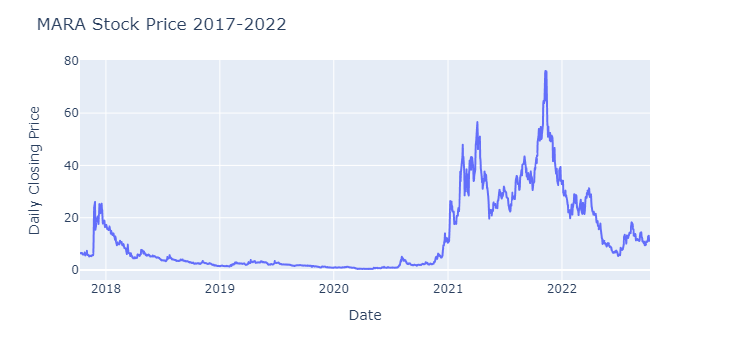

In [5]:
def plot_all(data=df, tck='MARA'):
    ''' Basic visual of a line plot of daily stock price overtime
    '''
    fig = px.line(df, x='Date', y="Price")
    fig.update_layout(title=tck+' Stock Price 2017-2022',
                       xaxis_title='Date',
                       yaxis_title='Daily Closing Price')
    fig.show()
plot_all()

# 3. Decomposition
For a continuous time series $F_{t}$ over a discrete-time period $t$, we can proceed in breaking down the series as a function following an **additive** method: $F_{t}$ = $d_t$ + $s_t$ + $r_t$ or a **multiplicative** one: $F_{t}$ = $d_t$ * $s_t$ * $r_t$, where $d_{t}$ is a trend component, $s_{t}$ is a seasonal (periodic) component, and $r_{t}$ is a residual component. 

In essence, the decomposition of a time series is the process by which we isolate all those single elements: trend, seasonality, and residual. This technique serves to disentangle the time series for a more comprehensive analysis, most importantly facilitate the forecasting process.

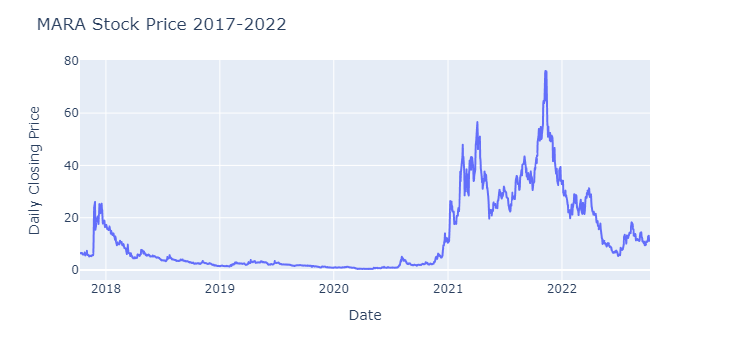

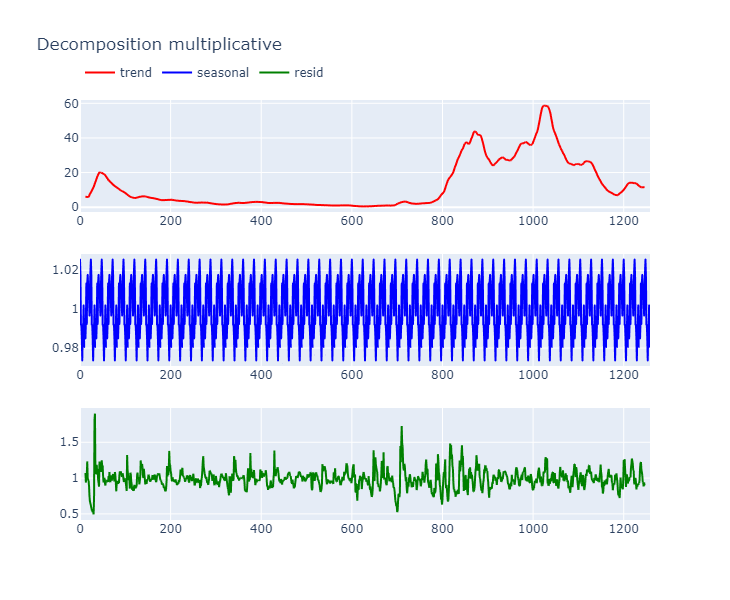

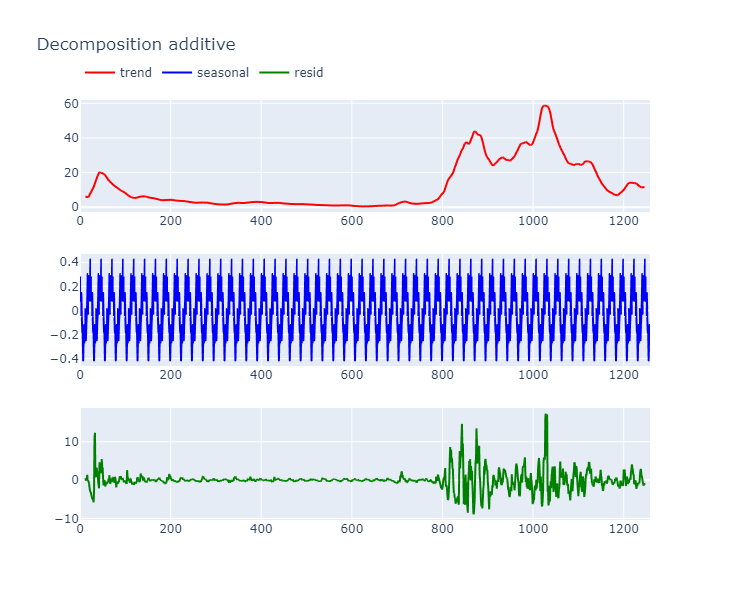

In [8]:
from statsmodels.tsa.seasonal import STL
def decompose_view(var=df['Price']):
    
    ''' Determine the suitable combination of base level, trend, seasonal index and the residual term.
    '''
    plot_all()
    #Troubleshoot for STL
    #data.index = [i for i in range(data.shape[0])]
    # var = 
    # data = data.asfreq('d')
    # data = data.fillna(method='bfill').fillna(method='ffill')
    # stl = STL(data["Price"].values, seasonal=12, robust = True)
    # res = stl.fit()
    # fig = res.plot()
    for mod in ['multiplicative','additive']:
        decomp_func = seasonal_decompose(var, model = mod, period=24)
        figures = [
            px.line(decomp_func.trend, color_discrete_map={'trend':'red'}), 
            px.line(decomp_func.seasonal, color_discrete_map={'seasonal':'blue'}),
            px.line(decomp_func.resid, color_discrete_map={'resid':'green'})
        ]
        components = ['Trend', 'Seasonality','Error']
        fig = make_subplots(rows=len(figures), cols=1) 

        for i, figure in enumerate(figures):
            for trace in range(len(figure["data"])):
                fig.append_trace(figure["data"][trace], row=i+1, col=1)

        fig.update_layout(title="Decomposition "+mod, 
                          height=600,
                         legend=dict(orientation="h",
                                     yanchor="top", y=1.1,
                                     xanchor="left", x=0)
                         )
        fig.show()

decompose_view()

**Takeaway**: We note less residuals found using the additive decomposition compared to the multiplicative.

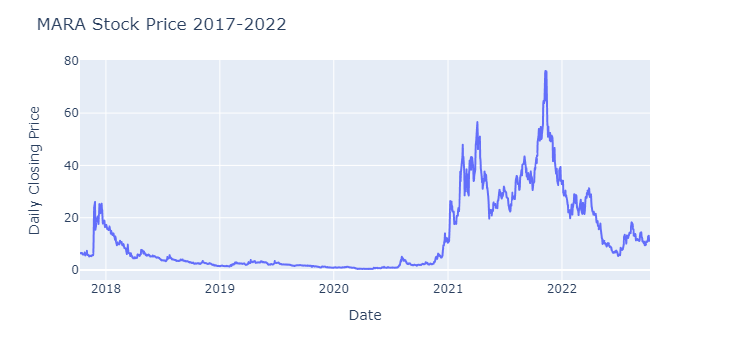

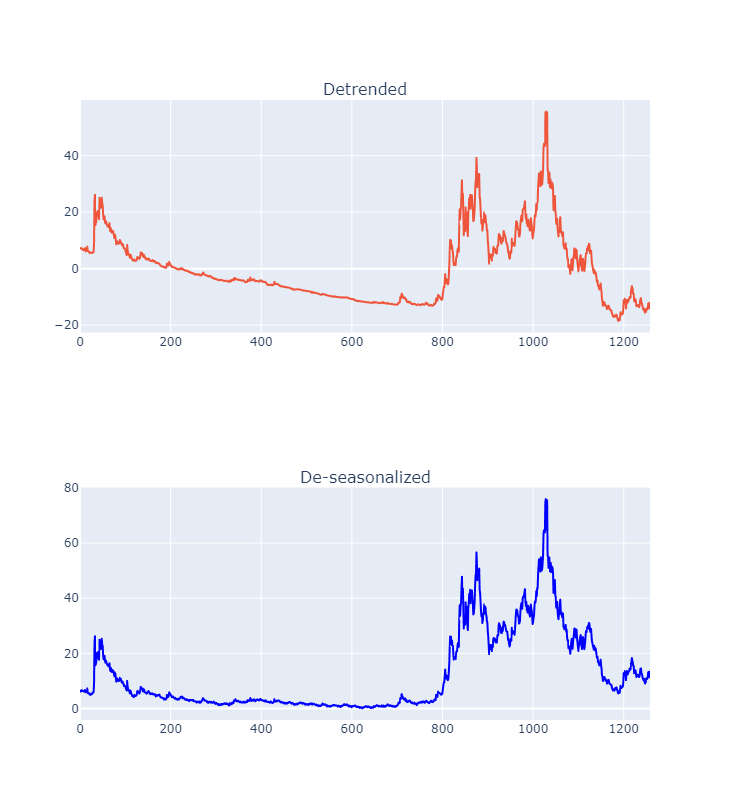

In [9]:
# Carry-over best decompositon method from last function

def decompose_action(var=df['Price'], tck='MARA'):
    ''' Decomposing the original data from its trend and seasonality
    '''
    #Detrend

    decomp = seasonal_decompose(var, model='additive', period=24)
    
    #Deseasonalize
    data = var.values
    # detrended = original_data - (decomp.trend)
    detrended = signal.detrend(data)
    dsz = data - (decomp.seasonal)

    figures = [
        px.line(detrended, color_discrete_map={0:'red'}), 
        px.line(dsz, color_discrete_map={'seasonal':'blue'})
    ]
    plot_all()
    
    fig = make_subplots(rows=len(figures), cols=1, subplot_titles=('Detrended','De-seasonalized')) 

    for i, figure in enumerate(figures):
        for trace in range(len(figure["data"])):
            fig.append_trace(figure["data"][trace], row=i+1, col=1)

    fig.update_layout(height=800,showlegend=False)
    fig.show()

decompose_action()

C:\Users\Graduate\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



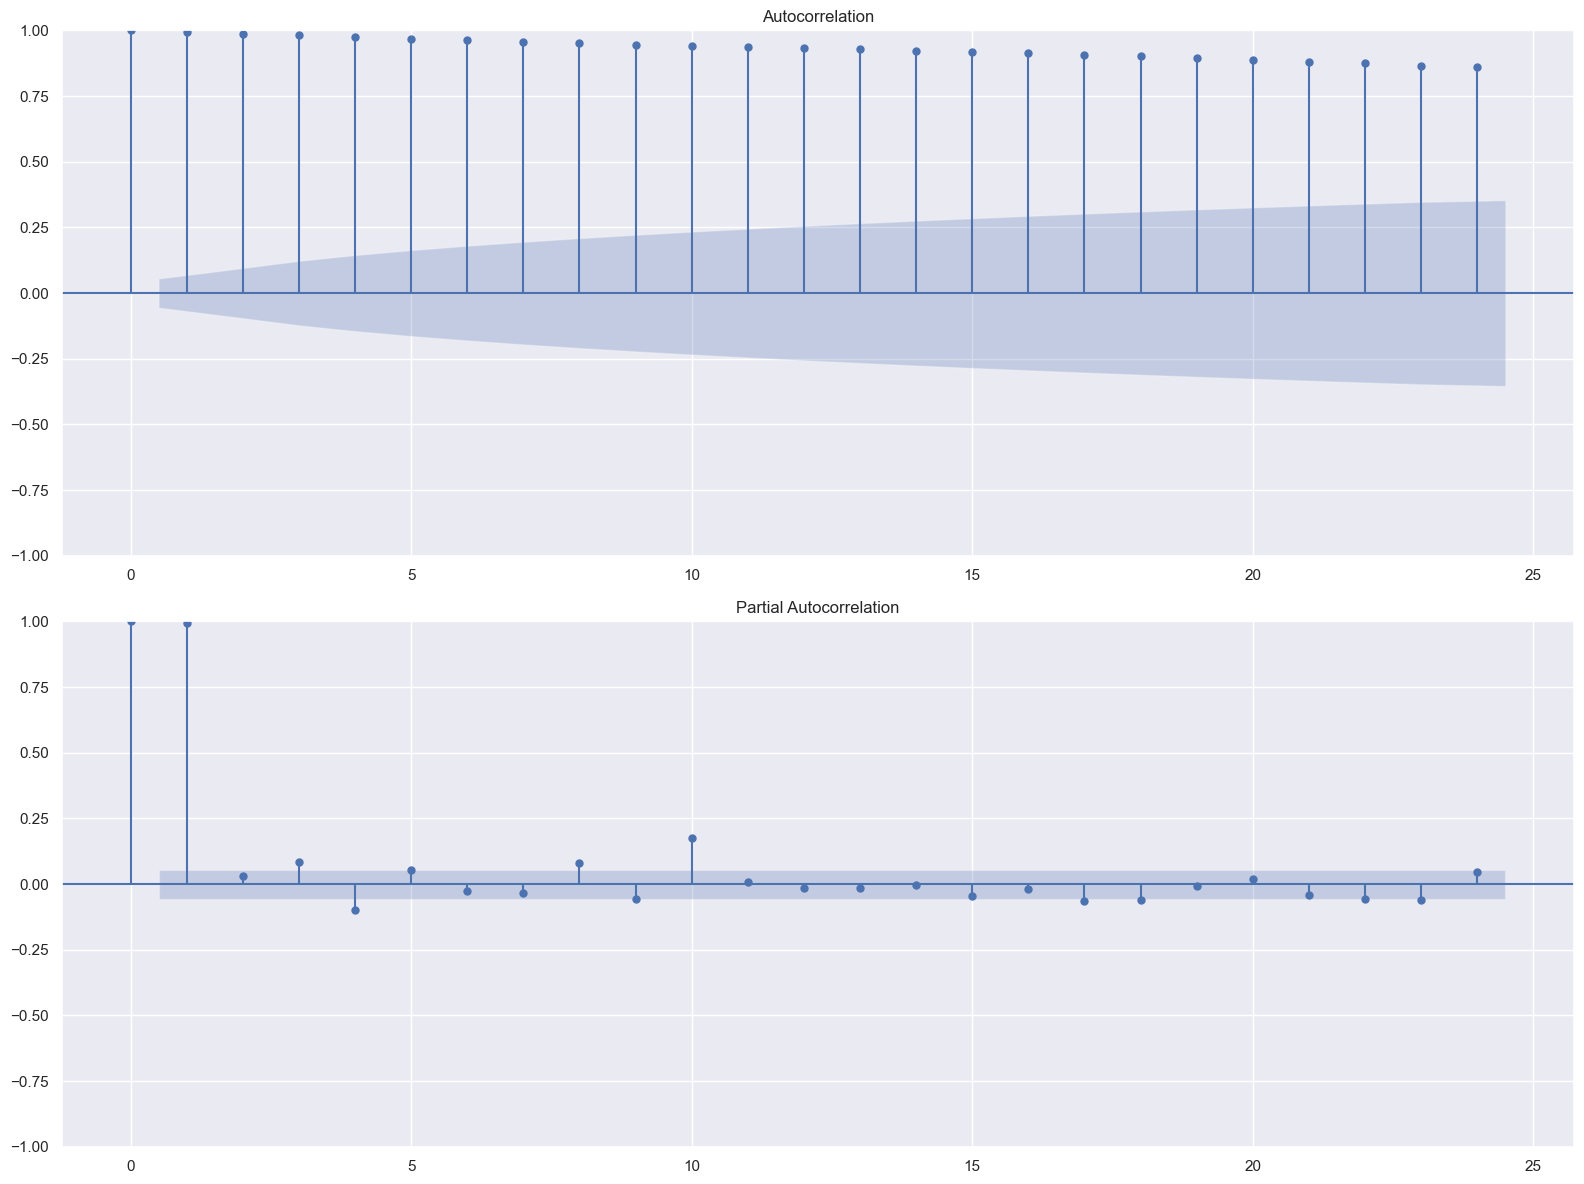

In [10]:
# Courtesy of : https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook
def acf_pacf(var=df['Price'], n=24):
    fig = plt.figure(figsize=(16,12))
    layout = (2, 1)
    # ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 0))

    # var.plot(ax=ts_ax)
    # p_value = sm.tsa.stattools.adfuller(var)[1]
    # ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(var, lags=n, ax=acf_ax)
    smt.graphics.plot_pacf(var, lags=n, ax=pacf_ax)
    plt.tight_layout()
    
    return
acf_pacf()

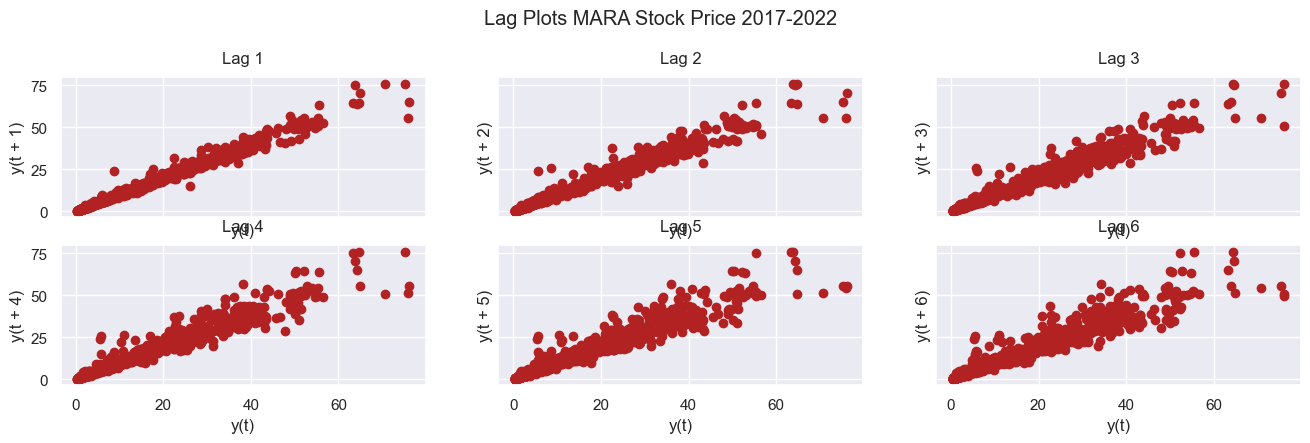

In [11]:
def lag_plots(var=df['Price'], tck='MARA'):
    from pandas.plotting import lag_plot
    plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(16,4), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()[:6]):
        lag_plot(var, lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))

    fig.suptitle('Lag Plots {} Stock Price 2017-2022'.format(tck), y=1.05)    
    plt.show()
    
lag_plots()

# Stationary
[Reference](https://machinelearningmastery.com/time-series-data-stationary-python/)

The **Augmented Dickey-Fuller** (ADF) test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

* Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
* Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

In [12]:
def DCF(var=df['Price']):
    result = adfuller(var)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    #return result
#     x = w = np.random.normal(size=n_samples)
#     for t in range(n_samples):
#         x[t] = rho * x[t-1] + w[t]

#     with plt.style.context('bmh'):  
#         plt.figure(figsize=(10, 3))
#         plt.plot(x)
#         plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
# for rho in [0, 0.6, 0.9, 1]:
#     plotProcess(rho=rho)
DCF()

ADF Statistic: -1.714804
p-value: 0.423502
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


**Takeaway:** In this instance, we fail to reject the null hypothesis, thus indicating that our time series for the MARA stock price is non-statinary. If we aim to predict future prices, we ought to make it stationary. There are reasons why we want to convert a non-stationary series into a stationary one. These are given below:

* More relaibale forecasting
* An important reason is, autoregressive forecasting models are essentially linear regression models that utilize the lag(s) of the series itself as predictors.
* Mitigating the issue of multi-colinearity for more robust linear regression models

We can apply some sort of transformation to make the time-series stationary. These transformation may include:
* Differencing the Series (once or more)
* Take the log of the series
* Take the nth root of the series
* Combination of the above

In our case scenario, we will use the **differencing** method

ADF Statistic: -13.712940
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


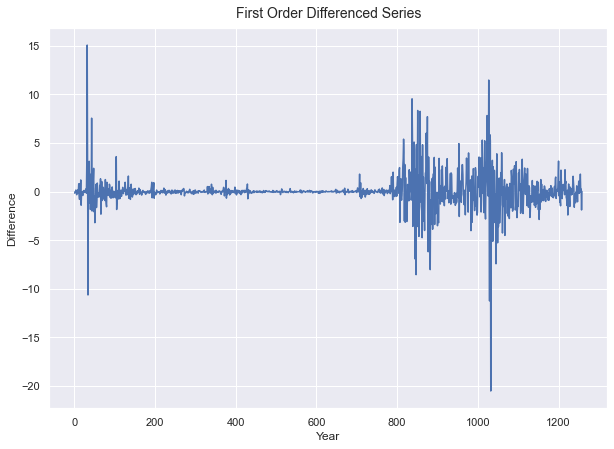

In [84]:
# Change for (t)th day is Close for (t)th day minus Close for (t-1)th day.
def stationarize_diff(var=df['Price']):
    df['Diff_1'] = var.diff()
    # result = adfuller(df.Difference.dropna())
    DCF(var=df['Diff_1'].dropna())
    # Plot the Change
    plt.figure(figsize=(10, 7))
    plt.plot(df['Diff_1'])
    plt.title('First Order Differenced Series', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.show()
    
stationarize_diff()

# Forecasting 
[Reference](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)
## ARIMA-family Crash-Course
We will explain this model by building up letter by letter.  SARIMA(p,d,q)(P,D,Q,s) , Seasonal Autoregression Moving Average model:

* AR(p)  - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as  p . To determine the initial  p , you need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.
* MA(q)  - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as  q . The initial value can be found on the ACF plot with the same logic as before.
Let's combine our first 4 letters:

* AR(p)+MA(q)=ARMA(p,q) 
What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

* I(d)  - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences.
Adding this letter to the four gives us the  ARIMA  model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

* S(s)  - this is responsible for seasonality and equals the season period length of the series
With this, we have three parameters:  (P,D,Q) 
* P  - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial  P  should be 2.

* Q  - similar logic using the ACF plot instead.

* D  - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.

Now that we know how to set the initial parameters, let's have a look at the final plot once again and set the parameters:

C:\Users\Graduate\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

C:\Users\Graduate\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

C:\Users\Graduate\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



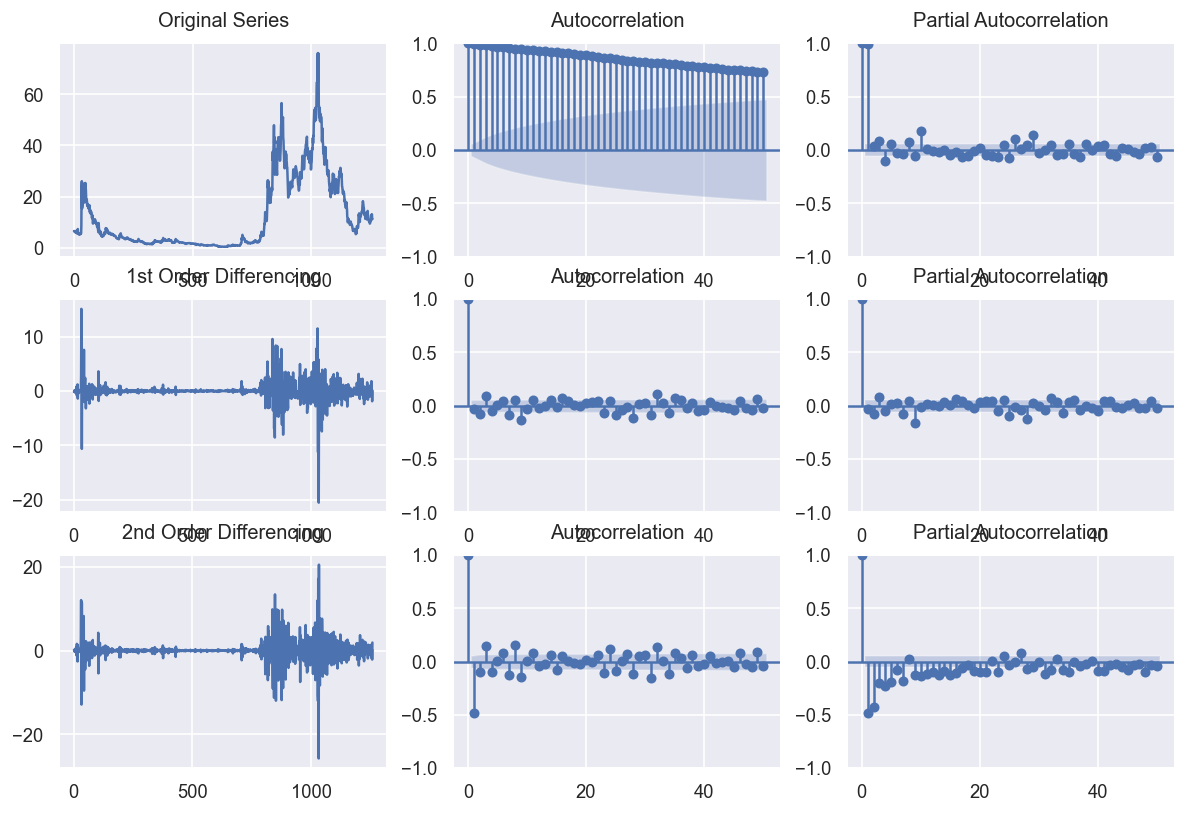

In [231]:
# Using this method to find the best 'd'
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':120})

# Original Series
var = df['Price'].values
fig, axes = plt.subplots(3,3, sharex=False)
axes[0, 0].plot(var); axes[0, 0].set_title('Original Series')

plot_acf(var, ax=axes[0, 1], lags=50)
plot_pacf(var, ax=axes[0, 2], lags=50)

# 1st Differencing
var = pd.Series(df['Price'].values)
axes[1, 0].plot(var.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(var.diff().dropna(), ax=axes[1, 1], lags=50)
plot_pacf(var.diff().dropna(), ax=axes[1, 2], lags=50)

# 2nd Differencing
axes[2, 0].plot(var.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(var.diff().diff().dropna(), ax=axes[2, 1], lags=50)
plot_pacf(var.diff().diff().dropna(), ax=axes[2, 2], lags=50)

plt.show()

**Noes:** 
* The ACF tells how many MA terms (q) are required to remove any autocorrelation in the stationarized series.
* You can find out the required number of AR terms (p) by inspecting the Partial Autocorrelation (PACF) plot.

In [61]:
# Create Training and Test
df.index = df['Date']
df.index = df.index.to_period('d')
train = df.Price[:800]
test = df.Price[800:]

C:\Users\Graduate\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1259
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2432.063
Date:                Sat, 15 Oct 2022   AIC                           4870.125
Time:                        08:27:17   BIC                           4885.537
Sample:                    10-10-2017   HQIC                          4875.917
                         - 10-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6501      0.206     -3.158      0.002      -1.054      -0.247
ma.L1          0.6814      0.198      3.447      0.001       0.294       1.069
sigma2         2.7973      0.028     98.277      0.0

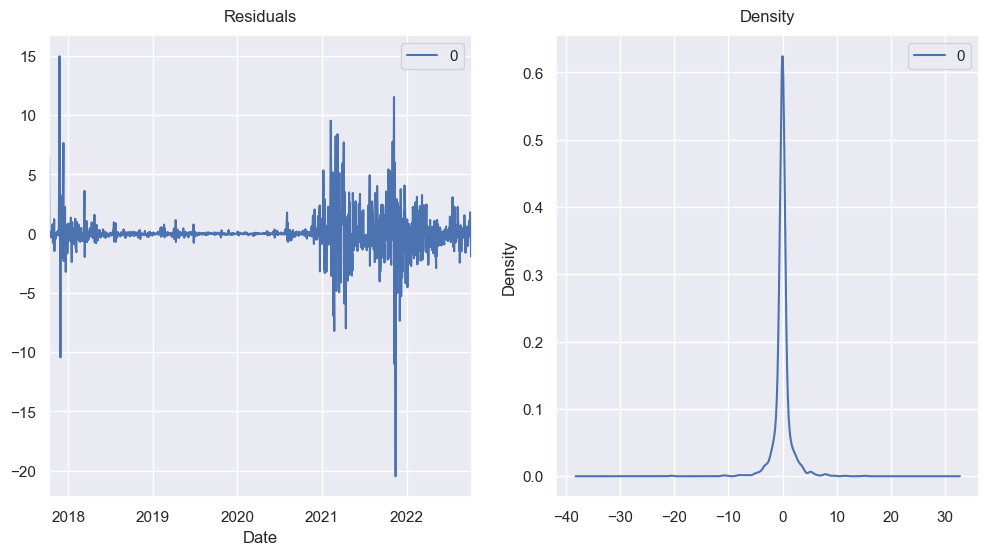

                 0
count  1259.000000
mean      0.008878
std       1.682702
min     -20.472961
25%      -0.250287
50%      -0.019031
75%       0.165167
max      14.978820


In [125]:
from statsmodels.tsa.arima.model import ARIMA
# df.index = df.index.to_period('d')
# def arima_modeling():
model = ARIMA(df.Price, order=(1,1,1))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())
    
# Plot residual errors
plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':100})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
print(residuals.describe())

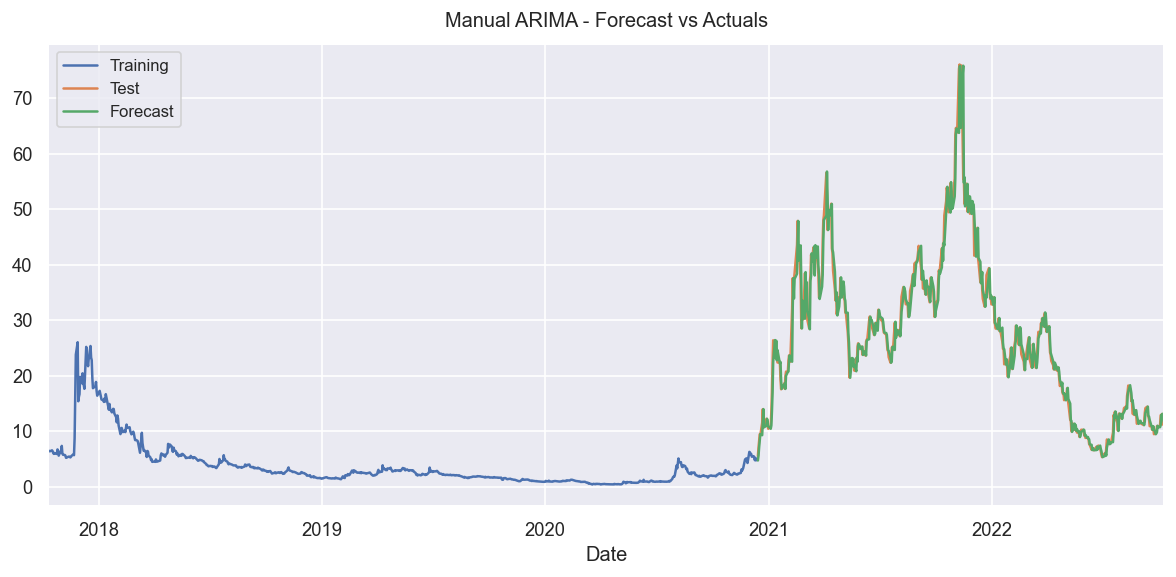

In [133]:
# forecast_test = 
# df['Forecast'] = model_fit.predict(60, alpha=0.05)
# fig = px.line(df, x='Date', y=['Price', 'Forecast'])
# fig.update_layout(title='Actual Price vs. Forecast',
#                    xaxis_title='Date',
#                    yaxis_title='Daily Closing Price')
# fig.show()

# Forecast using 95% confidence interval
# var = pd.Series(df['Price'].values)
# train = pd.Series(df.Price[:800].values)
# test = pd.Series(df.Price[800:].values)


# Make as pandas series
fc = model_fit.predict(start=800)

# Plot
# # df['forecast']=results.predict(start=90,end=103,dynamic=True)
# tr
# df['forecast'].plot(figsize=(12,8))
plt.figure(figsize=(12,5), dpi=120)
train.plot(label='Training')
test.plot(label='Test')
fc.plot(label='Forecast')
plt.title('Manual ARIMA - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [45]:
# Actual vs Fitted
import pmdarima as pm
auto_arima = pm.auto_arima(train, stepwise=True, seasonal=True)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2412.837
Date:                Sat, 15 Oct 2022   AIC                           4835.673
Time:                        07:54:15   BIC                           4861.360
Sample:                             0   HQIC                          4845.327
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3559      0.017    -82.004      0.000      -1.388      -1.324
ar.L2         -0.9430      0.017    -56.811      0.000      -0.976      -0.910
ma.L1          1.3486      0.022     62.398      0.000       1.306       1.391
ma.L2          0.8953      0.022     41.498      0.000       0.853       0.938
sigma2         2.7125      0.032     84.252      0.000       2.649       2.776
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             43741.11
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               4.72   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

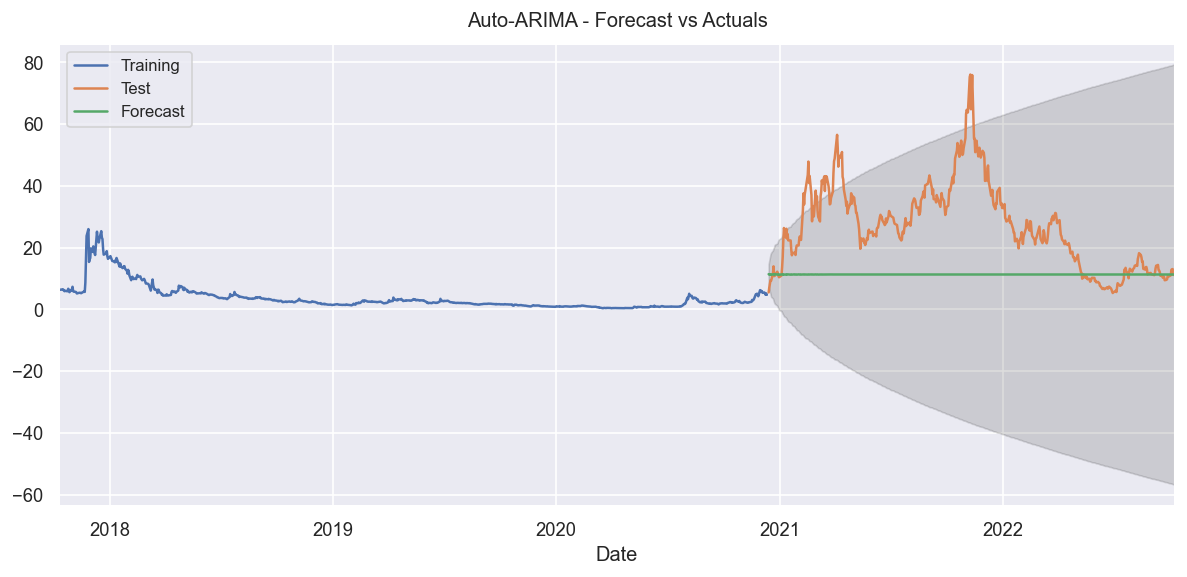

In [132]:
# forecast_test_auto = auto_arima.predict(n_periods=len(test))
# df['forecast_auto'] = [None]*len(train) + list(forecast_test_auto)

# df.plot()


# Make as pandas series
fc, conf = auto_arima.predict(n_periods=test.shape[0], return_conf_int=True)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
# # df['forecast']=results.predict(start=90,end=103,dynamic=True)
# tr
# df['forecast'].plot(figsize=(12,8))
plt.figure(figsize=(12,5), dpi=120)
train.plot(label='Training')
test.plot(label='Test')
fc_series.plot(label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Auto-ARIMA - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.show()